# Inaugural Project

Imports:

In [10]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Question 1

To create a solution function, we first set up the paramaters as a dictionary and define the utility function.

In [11]:
# a. Creating dictionary of given parameter
par = {"phi": 0.3, "epsilon": 0.5, "r": 0.03, "taug": 0.012, "taup": 0.004, "pbar": 3}

# b. Defining the utility-function
def u(c, h):
    """ Calculates the utility of the consumer for given consumption of housing and other consumption
    
    Args:
        c (float): consumption of other goods
        h (float): consumption of housing
    
    Returns:
        u (float): utility of consumption 
   
   """
    
    return c**(1-par["phi"])*h**par["phi"]

We then define a cost function for housing consumption, depending on the chosen paramaters.

In [12]:
def tau(h, parset):
    """ Calculates the costs for given level of housing consumptions and parameters"""
    
    return parset["r"]*h+parset["taug"]*h*parset["epsilon"]+parset["taup"]*max(h*parset["epsilon"]-parset["pbar"],0)

To optimize utility, given a specific income level and parameter set, we use the monotonicity quality of the Cobb-Douglas utility function (i.e. all income is spent in optimum, $m-\tau(p_h, \tilde{p}_h)-c=0)$ This allows us to set up a scalar solver, now that utility only depends on one variable.

In [13]:
# a. Negative utility
def negconsutil(h, m, parset):
    """ Return negative utility as a function of income, housing and parameters"""
    
    #i. other consumption as a function of income and housing
    c = m-tau(h, parset)
    
    #ii. negative utility
    return -u(c, h)

# b. Creating solver
def solve(m, parset):
    """ Solves the consumers utility maximization problem"""
    
    #i. solving
    sol_cons = optimize.minimize_scalar(negconsutil, args=(m, parset))
    
    #ii. saving
    h = sol_cons.x
    c = m-tau(h, parset)
    util = u(c, h)
    
    return h, c, util

Solving for an income $m=0.5$ and the given parameter values, we get

In [14]:
solve(0.5, par)

(4.1666666039527485, 0.35000000225770106, 0.7358414678061572)

I.e. the optimal consumption bundle consists of $h^*=4.17$ and $c^*=0.35$, so that the optimal utility level is $u=0.74$.

# Question 2

To begin with, we set up 1,000 different income levels in the given interval and calculate their respective optimal consumption bundles.  

In [15]:
# a. Number of observations
N=1000

# b. Empty lists
c_values = []
h_values = []
m_values = []

# c. optimal consumption over income distribution
for i in np.linspace(0.4,2.5,N):
    a_i = solve(i, par)
    c_values.append(a_i[1])
    h_values.append(a_i[0])
    m_values.append(i)

From this, we plot the different optiomal consumption levels of housing, resp. consumption, against income.

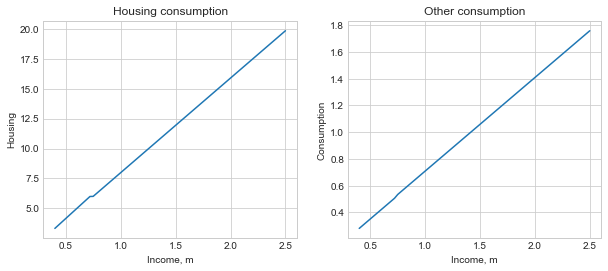

In [17]:
plt.style.use("seaborn-whitegrid")

# a. create the figure
fig = plt.figure(figsize=(10,4))

# b. left plot
ax_left = fig.add_subplot(1,2,1)

ax_left.plot(m_values,h_values)

ax_left.set_title('Housing consumption')
ax_left.set_xlabel('Income, m')
ax_left.set_ylabel('Housing')
ax_left.grid(True)

# c. right plot
ax_right = fig.add_subplot(1,2,2)

ax_right.plot(m_values,c_values)

ax_right.set_title('Other consumption')
ax_right.set_xlabel('Income, m')
ax_right.set_ylabel('Consumption')
ax_right.grid(True)

This gives us the two Engel curves, illustrated in the figures above. Here we note the plateu in housing consumption around $h=6$, where public assesment reaches $\tilde{p}_h=3$, thus activating the progressive tax. More on this in question 3.

# Question 3

In [23]:
np.random.seed(1)

We simulate 10.000 draws from a lognormal distribution (and illustrate them for good measure):

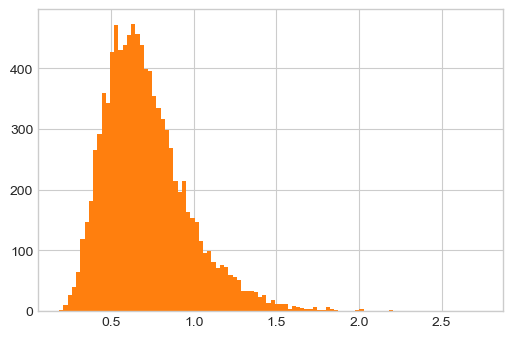

In [24]:
# a. creating income distribution
m_rand = np.random.lognormal(-0.4,0.35, size=10000)

# b. histogram
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(m_rand,bins=100,label='m_rand')
_junk = ax.hist(m_rand, bins=100)

We then optimize each of the 10.000 households' housing consumption, using our solver in a for loop, and plot them in a histogram.

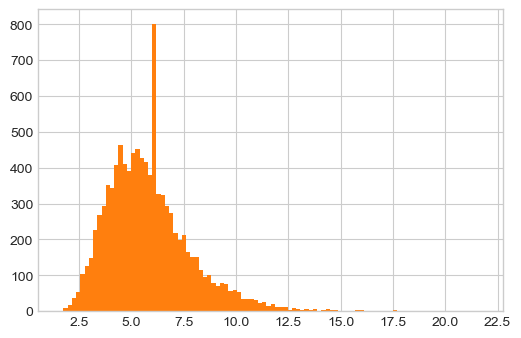

In [25]:
h_opt=np.empty(10000)

# a. solve for every income level
for i, m in enumerate(m_rand):
    h_i = solve(m, par)
    h_opt[i]= h_i[0]

# b. plotting solution
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(h_opt,bins=100,density=True,label='m_rand')
_junk = ax.hist(h_opt, bins=100)

Here we note, that a unusually large amount of households choose to optimize at $p_h=h=6$. This is due to the fact, that at this point the public assesment becomes $\tilde{p}_h=3$, which is where the progressive tax kicks in. Therefore, which we also see in our Engel curves, there will be an income span, where optimal housing consumption doesn't increase with the income, but instead remains at the threshold point $h=6$. 

We can now, finally, calculate the average collected tax revenue. This we do by creating a function for the tax collected from each household, given their choice of consumption based on the parameter values, and then calculating the average.

In [26]:
# a. tax collected
def taxcol(h, parset):
    """returns the taxrevenue for given level of housing consumption """
    
    return parset["taug"]*h*parset["epsilon"]+parset["taup"]*max(h*parset["epsilon"]-parset["pbar"],0)

# b. average tax burden
def avgtax(h_list, parset, N=10000):
    """returns the average tax burden pr. households"""
    
    #i. creating variable
    taxrev = 0.0
    
    #ii. solving for each household
    for h in h_list: 
        taxrev+=taxcol(h, parset)
    return taxrev/N   

# c. solving for calculated optimal consumption
avgtax(h_opt, par)

0.03632680342536602

The average tax burden pr. household is then 36,327DKK. 

# Question 4

We set up our new parameter set and re-calculate the optimal housing consumption for our simulated households, once again plotting the results in a histogram.

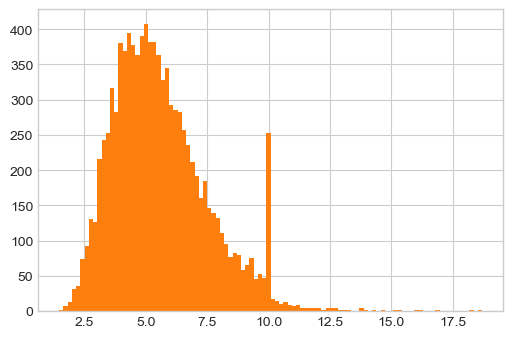

In [28]:
# a. new parameters
par2 = {"phi": 0.3, "epsilon": 0.8, "r": 0.03, "taug": 0.01, "taup": 0.009, "pbar": 8}

# b. solving for optimal consumption
h_opt2=np.empty(10000)

for i, m in enumerate(m_rand):
    h_i = solve(m, par2)
    h_opt2[i]= h_i[0]

# c. plotting distribution of consumption
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(h_opt2,bins=100,density=True,label='m_rand')
_junk = ax.hist(h_opt2, bins=100)


We note, that the housing consumption plateu is now located at the new progressive tax threshold: 
$$\varepsilon h-\bar{p}=0.8\cdot h-8\Leftrightarrow h=10$$

The average tax burden is now

In [29]:
avgtax(h_opt2, par2)

0.04503629313721809

Or, in words, 45,036DKK pr. household.

# Question 5

We now redo the household simulation with fewer draws, so as to make the calculations feasible for our computer. 

In [33]:
# a. set seed
np.random.seed(1)

# b. create income distribution
m_rand2 = np.random.lognormal(-0.4,0.35, size=1000)

From this we create a for loop, going thorugh a fine-meshed range of possible $\tau^g$'s, resetting the paramater values each time. For each of these loops, the 1,000 simulated households will optimize under the given conditions, paying a sepcific average tax. We then use this to see, which tax level results in an (almost) identical average tax burden. 

In [34]:
# a. unchanged average tax payment
for taug in np.linspace(0,0.01,100):
    par_taug = {"phi": 0.3, "epsilon": 0.8, "r": 0.03, "taug": taug, "taup": 0.009, "pbar": 8}
    h_taug = np.empty(1000)
    #i. optimal consumption with new parameters
    for i, m in enumerate(m_rand2):
        h_i = solve(m, par_taug)
        h_taug[i] = h_i[0]
    #ii. taug that meets requirements
    if abs(avgtax(h_taug, par_taug)-avgtax(h_opt, par))<0.0001:
        print(taug)

Thus, we get that $\tau^g$ should be lowered to be around $.74$%.

# Conclusion

In this project we have defined a function, which solves the consumer maximization problem, indicated by the model we where given. 

We have investigated, how the distribution of consumption on housing will look like, when assuming a given lognormal income distribution. Not suprisingly, we found that the distribution of housing is affected by the progressive housing tax, meaning the many households will choose a optimal housing consumption just below the cutoff value. 

Given this distribution of consumption we have calculated the average tax payment per household. We have also investaged what level of base housing tax will make sure that the average home owner does not pay more in taxes, when the policy makers seem to be interested in taxing high-income home owners harder. 